### Dependents
***

In [65]:
from matplotlib import dates
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy
from sqlalchemy import asc, and_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import matplotlib.patches as mpatches
from flask import Flask, jsonify

### Ensure data loads
***

In [4]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [5]:
# Ensuring tables are present
inspector = inspect(engine)
inspector.get_table_names()

['measure', 'stations']

In [6]:
# Looking at the columns of the Measure table
columns = inspector.get_columns('measure')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR
precip FLOAT
tobs INTEGER
date DATETIME


In [7]:
# Looking at the colums of the Stations table
columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT
name VARCHAR
country VARCHAR
state VARCHAR


In [8]:
# Executing a select to ensure good connection to the database
engine.execute('SELECT * FROM measure LIMIT 5').fetchall()

[(1, 'USC00519397', 0.08, 65, '2010-01-01 00:00:00.000000'),
 (2, 'USC00519397', 0.0, 63, '2010-01-02 00:00:00.000000'),
 (3, 'USC00519397', 0.0, 74, '2010-01-03 00:00:00.000000'),
 (4, 'USC00519397', 0.0, 76, '2010-01-04 00:00:00.000000'),
 (5, 'USC00519397', 0.0, 73, '2010-01-06 00:00:00.000000')]

In [9]:
engine.execute('SELECT * FROM stations LIMIT 5').fetchall()

[(1, 'USC00519397', 21.2716, -157.8168, 3.0, 'WAIKIKI 717.2', 'US', 'HI'),
 (2, 'USC00513117', 21.4234, -157.8015, 14.6, 'KANEOHE 838.1', 'US', 'HI'),
 (3, 'USC00514830', 21.5213, -157.8374, 7.0, 'KUALOA RANCH HEADQUARTERS 886.9', 'US', 'HI'),
 (4, 'USC00517948', 21.3934, -157.9751, 11.9, 'PEARL CITY', 'US', 'HI'),
 (5, 'USC00518838', 21.4992, -158.0111, 306.6, 'UPPER WAHIAWA 874.3', 'US', 'HI')]

### Database Queries to Answer Question and to Plot
***

In [10]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Measure = Base.classes.measure

In [11]:
session = Session(engine)

In [12]:
session.query(func.sum(Measure.precip)).all()

[(2908.1299999999706)]

In [13]:
# Querying the database for records over the past 12 months
date_precip = session.query(Measure.date, Measure.precip).\
    filter(Measure.date > '2016-12-01').\
    order_by(Measure.date).all()

In [14]:
# Creating a dataframe with the results of the SELECT statement
date_precip_df = pd.DataFrame(date_precip)

In [15]:
# Setting the index to DATE
date_precip_df = date_precip_df.set_index('date')

In [16]:
date_precip_df.head()

,precip
date,
2016-12-01,0.12
2016-12-01,0.33
2016-12-01,0.07
2016-12-01,0.00
2016-12-01,0.16


In [17]:
# Saving the indexes as labels or xticks
date_precip_index = date_precip_df.index

In [18]:
date_precip_index

DatetimeIndex(['2016-12-01', '2016-12-01', '2016-12-01', '2016-12-01',
               '2016-12-01', '2016-12-01', '2016-12-01', '2016-12-02',
               '2016-12-02', '2016-12-02',
               ...
               '2017-08-21', '2017-08-21', '2017-08-21', '2017-08-22',
               '2017-08-22', '2017-08-22', '2017-08-23', '2017-08-23',
               '2017-08-23', '2017-08-23'],
              dtype='datetime64[ns]', name='date', length=1597, freq=None)

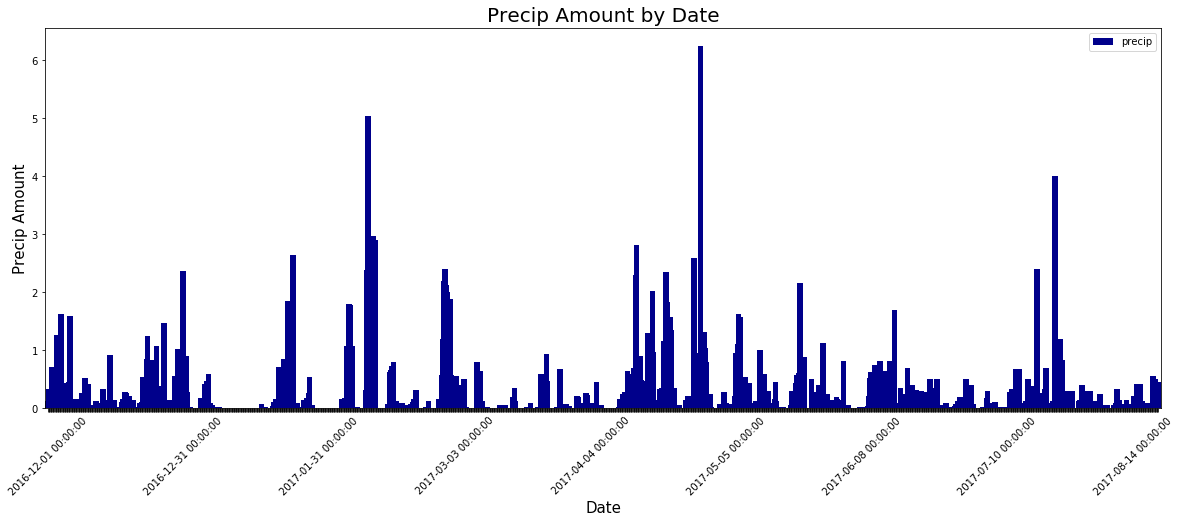

In [64]:
# Generating a plot of all 1500 date/precipation records
# Given the number of xtick labels, I found a nice function to declutter the plot
fig, ax = plt.subplots(figsize=(20,7))
date_precip_df.plot(kind='bar', y='precip', ax=ax, width=8, color='darkblue')
plt.title('Precip Amount by Date', size=20)
plt.xlabel('Date', size=15)
plt.ylabel('Precip Amount', size=15)
plt.xticks(rotation=45)
#ax = plt.gca()
#ax.set_facecolor('white')
#plt.grid(True, axis='x')
n = 195
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
plt.show()

### Database Queries to Answer Questions
***

In [20]:
# Station name and the number of observations by station - ordered by station name
stat_count = session.query(Measure.station, func.count(Measure.station)).group_by(Measure.station)
for count in stat_count:
    print(count)

('USC00511918', 1979)
('USC00513117', 2709)
('USC00514830', 2202)
('USC00516128', 2612)
('USC00517948', 1372)
('USC00518838', 511)
('USC00519281', 2772)
('USC00519397', 2724)
('USC00519523', 2669)


In [21]:
# Printing the stations and observation counts - descending order
# Printing the station with the most observations
highest_count=0
stat_count = session.query(Measure.station, func.count(Measure.station))\
.group_by(Measure.station)\
.order_by(func.count(Measure.station).asc())
for station, count in stat_count:
    print(station, count)
    if count > highest_count:
        highest_count = count
        high_stat_name = station

print('The station with the highest number of observations is', high_stat_name, 'with a count of',highest_count, '.')

USC00518838 511
USC00517948 1372
USC00511918 1979
USC00514830 2202
USC00516128 2612
USC00519523 2669
USC00513117 2709
USC00519397 2724
USC00519281 2772
The station with the highest number of observations is USC00519281 with a count of 2772 .


In [22]:
# Switching to the stations table
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.stations

In [23]:
session = Session(engine)

In [24]:
# Total number of stations
session.query(func.count(Station.station)).all()

[(9)]

### Producing a histogram
***

In [25]:
date_tobs = session.query(Measure.date, Measure.tobs).\
    filter(Measure.date > '2016-12-01').\
    order_by(Measure.date).all()

In [26]:
date_tobs_df = pd.DataFrame(date_tobs)

In [27]:
date_tobs_df.head()

,date,tobs
0,2016-12-01,75
1,2016-12-01,73
2,2016-12-01,75
3,2016-12-01,72
4,2016-12-01,76


In [28]:
date_tobs_df.dtypes

date    datetime64[ns]
tobs             int64
dtype: object

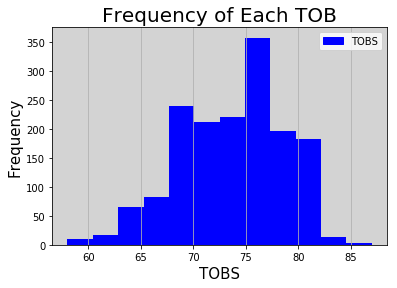

In [57]:
plt.hist(date_tobs_df['tobs'], bins=12, color='blue')
plt.title('Frequency of Each TOB', size=20)
plt.xlabel('TOBS', size=15)
plt.ylabel('Frequency', size=15)
plt_patch = mpatches.Patch(color='blue', label='TOBS')
ax = plt.gca()
ax.set_facecolor('lightgray')
plt.grid(True, axis='x')
plt.legend(handles=[plt_patch])
plt.show()

### Creating a function to calculate min, max and mean TOBs
***

In [30]:
# Vacation dates
vac_dates = ['2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04', '2016-12-05', '2016-12-06',\
            '2016-12-07','2016-12-08','2016-12-09','2016-12-10','2016-12-11','2016-12-12','2016-12-13',\
            '2016-12-14','2016-12-15','2016-12-16','2016-12-17','2016-12-18','2016-12-19','2016-12-20']

In [31]:
# Calculation function with 2 inputs
def calc_temps(start_date, end_date):
    date_tobs = session.query(Measure.date, Measure.tobs).\
    filter(and_(Measure.date >= start_date, Measure.date <= end_date)).all()
    date_tobs_df = pd.DataFrame(date_tobs)
    min_tob = date_tobs_df['tobs'].min()
    max_tob = date_tobs_df['tobs'].max()
    mean_tob = date_tobs_df['tobs'].mean()
    return min_tob, max_tob, mean_tob

In [32]:
# Unpacking the functions output into 3 variables
c_min, c_max, c_mean = calc_temps(vac_dates[0], vac_dates[-1])

In [33]:
print('The minimun TOB is ',c_min)
print('The maximum TOB is ',c_max)
print('The average TOB is ',c_mean)

The minimun TOB is  60
The maximum TOB is  78
The average TOB is  70.47154471544715


### Plotting the min, max, mean and errorbar of temperature data
***

In [51]:
city = ["Warm City"]
avg_temp = [c_mean]
x_axis = np.arange(len(avg_temp))
delta_temp = c_max - c_min

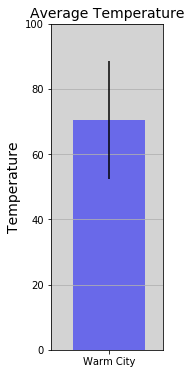

In [53]:
plt.figure(figsize = (2, 6))
plt.bar(x_axis, avg_temp, yerr = delta_temp, color="blue", alpha = 0.5, align="edge") 
tick_locations = [value+0.4 for value in x_axis]
plt.xticks(tick_locations, city)
plt.xlim(-0.25, len(x_axis))
plt.ylim(0, 100, 5)
ax = plt.gca()
ax.set_facecolor('lightgray')
plt.grid(True, axis='y')
plt.ylabel('Temperature', fontsize = 14)
plt.title('Average Temperature', fontsize = 14)
plt.show()

### Combining Flask and previous work to create an API
***

In [82]:
# Database Setup
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [83]:
# Reflect an existing database into a new model
Base = automap_base()

In [84]:
# Reflect the tables
Base.prepare(engine, reflect=True)

In [85]:
# Save reference to the table
Measure = Base.classes.measure
Station = Base.classes.stations

In [86]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [87]:
# Flask Setup
app = Flask(__name__)

In [99]:
# Flask Routes
start_date='2017-02-01'
end_date='2018-02-01'

@app.route("/")
def welcome1():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.1/precipitation<br/>"
        f"/api/v1.1/stations<br/>"
        f"/api/v1.1/tobs<br>"
        f"/api/v1.1/<start_date> & /api/v1.1/<end_date>")


@app.route("/api/v1.1/precipitation")
def date_tob():
	"""Return a list of all dates and temps from last year"""
	# Query all dates and temps
	results = session.query(Measure.date, Measure.tobs).filter(Measure.date > '2017-02-01').order_by(Measure.date).all()
	# Convert list of tuples into normal list
	data = list(np.ravel(results))

	return jsonify(data)

@app.route("/api/v1.1/stations")
def station():
    """Return a list of all stations"""
    # Query all stations
    results = session.query(Station.station).all()

    return jsonify(results)

@app.route("/api/v1.1/tobs")
def temp():
    """Return a list of all dates and temps from last year"""
    # Query all temps
    results = session.query(Measure.tobs).\
    filter(Measure.date > '2017-02-01').\
    order_by(Measure.date).all()

    # Convert list of tuples into normal list
    data = list(np.ravel(results))

    return jsonify(data)

@app.route("/api/v1.1/<start_date> and /api/v1.1/<end_date>")
def temp_tob():
    """Return a list of all dates and temps from last year"""
    # Query all dates and temps
    results_start_end = session.query(Measure.date, Measure.tobs).\
    filter(and_(Measure.date >= start_date, Measure.date <= end_date)).all()
    results_start_end_df = pd.DataFrame(results_start_end)
    
    range_min_tob = results_start_end_df['tobs'].min()
    range_max_tob = results_start_end_df['tobs'].max()
    range_mean_tob = results_start_end_df['tobs'].mean()

    results_start = results_start_end[results_start_end['date'] == start_date]
    results_end = results_start_end[results_start_end['date'] == end_date]
    
    results_start_min = results_start['tobs'].min()
    results_start_max = results_start['tobs'].max()
    results_start_mean = results_start['tobs'].mean()
    
    results_end_min = results_start['tobs'].min()
    results_end_max = results_start['tobs'].max()
    results_end_mean = results_start['tobs'].mean()

    return jsonify(results_start_min, results_start_max, results_start_mean,\
                  results_end_min, results_end_max, results_end_mean,\
                  range_min_tob, range_max_tob, range_mean_tob)

if __name__ == '__main__':
    app.run(debug=True)

OSError: [Errno 48] Address already in use